In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class Net(nn.Module):

    def __init__(self, n_input, n_output, n_layer, n_nodes):
        super(Net, self).__init__()
        self.n_layer = n_layer
        
        self.Input = nn.Linear(n_input, n_nodes)
        nn.init.xavier_uniform_(self.Input.weight)
        nn.init.normal_(self.Input.bias)

        self.Output = nn.Linear(n_nodes, n_output)
        nn.init.xavier_uniform_(self.Output.weight)
        nn.init.normal_(self.Output.bias)
        
        self.Hidden = nn.ModuleList()
        for i in range(n_layer):
            self.Hidden.append(nn.Linear(n_nodes, n_nodes))
        for layer in self.Hidden:
            nn.init.xavier_uniform_(layer.weight)
            nn.init.normal_(layer.bias)
        
    def forward(self, x):
        y = torch.tanh(self.Input(x))
        for layer in self.Hidden:
            y = torch.tanh(layer(y))
        y = self.Output(y)
        return y

In [3]:
def derivatives_1(x, Net, func):
    
    w = Net(x)*(func(x).view(-1,1))
    #print(Net(x),func(x).view(-1,1),w)
    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)

    return w, dw_x, dw_y

In [4]:
def derivatives_2(x, Net, func):
    
    w = Net(x)*(func(x).view(-1,1))
    #print(Net(x),func(x).view(-1,1),w)
    dw_xy = torch.autograd.grad(w, x, torch.ones_like(w), retain_graph=True,
    create_graph=True, allow_unused=True)
    dw_x = dw_xy[0][:,0].view(-1,1)
    dw_y = dw_xy[0][:,1].view(-1,1)
    
    # second partial derivative
    dw_xxy = torch.autograd.grad(dw_x, x, torch.ones_like(dw_x), retain_graph=True,
    create_graph=True,allow_unused=True)
    dw_xx = dw_xxy[0][:,0].view(-1,1)
    dw_xy = dw_xxy[0][:,1].view(-1,1)
    dw_yy = torch.autograd.grad(dw_y, x, torch.ones_like(dw_y), retain_graph=True,
    create_graph=True,allow_unused=True)[0][:,1].view(-1,1)
 
    return w, dw_x, dw_y, dw_xx, dw_yy, dw_xy

In [5]:
def Energy_density(x, Net_w, func_w, Net_u, func_u, Net_v, func_v):
    
    E = 70
    mu = 0.3
    h = 0.1
    q = 0.01
    D = E*h**3/(1-mu**2)/12.
    C = E*h/(1 - mu**2)
    a = 1
    b = 1
    
    w, dw_x, dw_y, dw_xx, dw_yy, dw_xy = derivatives_2(x, Net_w, func_w)
    _, du_x, du_y = derivatives_1(x, Net_u, func_u)
    _, dv_x, dv_y = derivatives_1(x, Net_v, func_v)
    
    w = w*h
    dw_x, dw_y, du_y, dv_x = dw_x*h/a, dw_y*h/b, du_y*a/b, dv_x*b/a
    dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b
    
    eps_xx = du_x + 0.5*dw_x**2
    eps_yy = dv_y + 0.5*dw_y**2
    eps_xy = 0.5*(du_y + dv_x) + dw_y*dw_x
    
    
    N_xx = C*(eps_xx + mu*eps_yy)
    N_yy = C*(eps_yy + mu*eps_xx)
    N_xy = C*(1 - mu)*eps_xy
    
    k_xx = -dw_xx
    k_yy = -dw_yy
    k_xy = -dw_xy
    
    M_xx = D*(k_xx + mu*k_yy)
    M_yy = D*(k_yy + mu*k_xx)
    M_xy = D*(1 - mu)*dw_xy
    
    #U_m = 0.5*C*(eps_xx**2 + eps_yy**2 + 2*mu*eps_xx*eps_yy + 2*(1-mu)*eps_xy**2)
    #U_b = 0.5*D*(k_xx**2 + k_yy**2 + 2*mu*k_xx*k_yy + 2*(1-mu)*k_xy**2)
    
    U_m = 0.5*(eps_xx*N_xx + eps_yy*N_yy + 2*eps_xy*N_xy)
    U_b = 0.5*(k_xx*M_xx + k_yy*M_yy + 2*k_xy*M_xy)
    U_e = q*w 
    
    return torch.mean(U_m), torch.mean(U_b), torch.mean(U_e)

In [6]:
def train_data(Nx, Ny, Nf):
    
    #a = 100
    #b = 100
    x = np.linspace(-1,1,Nx).reshape([Nx,1])
    y = np.linspace(-1,1,Ny).reshape([Ny,1])
    
    X, Y = np.meshgrid(x, y)
    Xf1 = np.vstack([X.ravel(), Y.ravel()]).T
    Xf1 = torch.tensor(Xf1, dtype=torch.float32, requires_grad=True)

    Xf2 = np.random.rand(Nf,2)*2-1
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)
    return Xf1, Xf2

In [7]:
# Prepare training data
Nx1 = 25
Ny1 = 25
Nf1 = 8000

Xf1, Xf2 = train_data(Nx1, Ny1, Nf1)
#X_int, _ = train_data(Nx2, Ny2, Nf2)

#print(X_int)
# Construct neural network
Net_w = Net(2, 1, 5, 5)
Net_u = Net(2, 1, 5, 5)
Net_v = Net(2, 1, 5, 5)


In [8]:
# CCFF boundary condition (Clamped on x=-1, x=1; Free on y=-1, y=1)
func_w = lambda x: ((x[:,0]+1)**2)*((x[:,0]-1)**2)               # Enforce w=0 and ∂w/∂x=0 at x=±1
func_u = lambda x: (x[:,0]+1)*(x[:,0]-1)                         # Enforce u=0 at x=±1
func_v = lambda x: (x[:,0]+1)*(x[:,0]-1)                         # Enforce v=0 at x=±1

In [9]:
# Construct neural network
# optimizer
nepoches = 5000
learning_rate = 1e-3
# optimizer_w = torch.optim.Adam(Net_w.parameters(), lr=learning_rate)
# optimizer_f = torch.optim.Adam(Net_f.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(list(Net_w.parameters()) + list(Net_u.parameters()) + list(Net_v.parameters()), 
                             lr= learning_rate)
for epoch in range(nepoches):
    ## Calculate loss
    U_m, U_b, U_e = Energy_density(Xf2, Net_w, func_w, Net_u, func_u, Net_v, func_v)
    
    loss = U_m + U_b - U_e
    #loss = simpson2d(U, Nx1, 0, 1, 0, 1)
    
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    #if (epoch+1) % 20 == 0:
    #Xf1, Xf2 = train_data(Nx1, Ny1, Nf1)
        
    if (epoch+1) % 100 == 0:
        print(f'epoch:{epoch+1}, Total:{loss:.4e}, Membrane:{U_m:.4e}, Bending:{U_b:.4e}, External:{U_e:.4e}')

epoch:100, Total:1.0145e-02, Membrane:7.2118e-03, Bending:1.8261e-03, External:-1.1075e-03
epoch:200, Total:2.5110e-03, Membrane:1.1652e-03, Bending:6.7313e-04, External:-6.7265e-04
epoch:300, Total:1.1742e-03, Membrane:5.3102e-04, Bending:2.4080e-04, External:-4.0234e-04
epoch:400, Total:6.3922e-04, Membrane:3.7706e-04, Bending:6.0550e-05, External:-2.0161e-04
epoch:500, Total:3.4757e-04, Membrane:2.9725e-04, Bending:3.5212e-06, External:-4.6798e-05
epoch:600, Total:1.7337e-04, Membrane:2.3635e-04, Bending:7.9197e-06, External:7.0892e-05
epoch:700, Total:7.1043e-05, Membrane:1.8920e-04, Bending:3.5885e-05, External:1.5404e-04
epoch:800, Total:1.1412e-05, Membrane:1.5409e-04, Bending:6.4587e-05, External:2.0726e-04
epoch:900, Total:-2.5633e-05, Membrane:1.2743e-04, Bending:8.5135e-05, External:2.3820e-04
epoch:1000, Total:-5.1073e-05, Membrane:1.0637e-04, Bending:9.7241e-05, External:2.5469e-04
epoch:1100, Total:-6.9879e-05, Membrane:8.9442e-05, Bending:1.0350e-04, External:2.6282e-04


🔴 Maximum deflection: 0.051134 mm at (x=-0.0101, y=0.9192)


/tmp/ipykernel_780171/3092560947.py:59: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


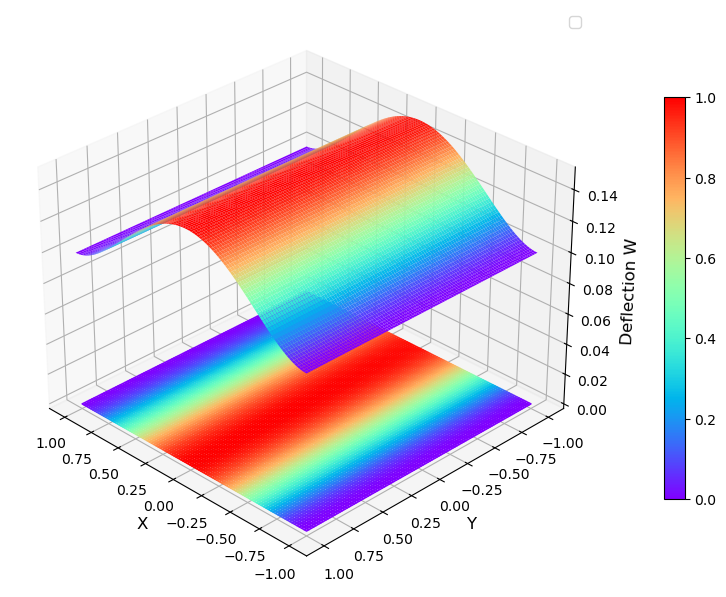

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

with torch.no_grad():
    # Plate dimensions
    a, b, h = 1, 1, 0.1

    # Create mesh grid
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    X_flat = torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype=torch.float32)

    # Evaluate networks
    W = Net_w(X_flat) * func_w(X_flat).view(-1, 1)
    U = Net_u(X_flat) * func_u(X_flat).view(-1, 1)
    V = Net_v(X_flat) * func_v(X_flat).view(-1, 1)

    # Reshape and scale
    W = W.numpy().reshape(100, 100) * h
    X_plot = X * a
    Y_plot = Y * b

    # 🔴 Find max deflection
    max_idx = np.unravel_index(np.argmax(W), W.shape)
    max_deflection = W[max_idx]
    max_x = X_plot[max_idx]
    max_y = Y_plot[max_idx]
    print(f"🔴 Maximum deflection: {max_deflection:.6f} mm at (x={max_x:.4f}, y={max_y:.4f})")

    # Normalize W for colormap
    W_norm = (W - np.min(W)) / (np.max(W) - np.min(W))

# Set vertical offset for 3D surface
z_offset = 0.1
W_raised = W + z_offset

# Create 3D plot
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# 🔷 3D surface (raised)
surf = ax.plot_surface(X_plot, Y_plot, W_raised, facecolors=cm.rainbow(W_norm), 
                       rstride=1, cstride=1, linewidth=0, antialiased=True, shade=False)

# 🔷 2D projection on z = 0
z_proj = np.zeros_like(W)
ax.plot_surface(X_plot, Y_plot, z_proj, facecolors=cm.rainbow(W_norm), 
                rstride=1, cstride=1, alpha=0.5, shade=False)


# Axes and labels
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Deflection W', fontsize=12)
ax.legend()

# Colorbar
mappable = cm.ScalarMappable(cmap=cm.rainbow)
mappable.set_array(W_norm)
cb = fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1)

# View angle and layout
ax.view_init(elev=30, azim=135)
plt.tight_layout()
plt.savefig('CCFF_3D_Raised_with_2D_Shadow.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()


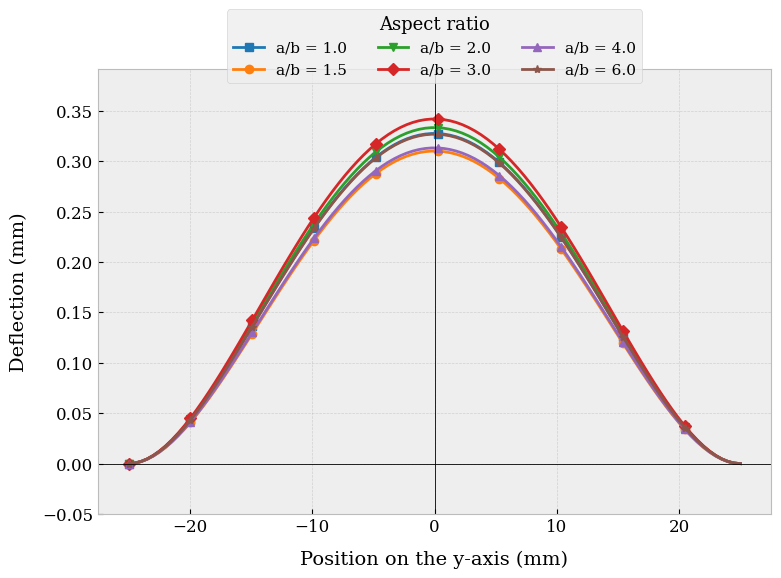

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Use beautiful plot settings
plt.style.use('bmh')  

plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 13,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'legend.fontsize': 11,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'lines.linewidth': 2,
    'lines.markersize': 6,
})

# File mapping (fixed b = 50)
files = {
    'a/b = 1.0': 'CCFF-deflection-AR-a50-b50.txt',
    'a/b = 1.5': 'CCFF-deflection-AR-a75-b50.txt',
    'a/b = 2.0': 'CCFF-deflection-AR-a100-b50.txt',
    'a/b = 3.0': 'CCFF-deflection-AR-a150-b50.txt',
    'a/b = 4.0': 'CCFF-deflection-AR-a200-b50.txt',
    'a/b = 6.0': 'CCFF-deflection-AR-a300-b50.txt',
}

points_per_curve = 100
b = 50  # Fixed length in mm
h = 0.1  # Thickness scaling

# Use aesthetically pleasing distinct colors
color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c',
               '#d62728', '#9467bd', '#8c564b']
markers = ['s', 'o', 'v', 'D', '^', '*']

fig, ax = plt.subplots(figsize=(8, 6))
all_W = []

for (label, file), color, marker in zip(files.items(), color_cycle, markers):
    data = np.loadtxt(file)[:points_per_curve]
    y_norm = np.linspace(-1, 1, points_per_curve)
    y_mm = y_norm * b / 2
    W = data * h
    all_W.extend(W)

    ax.plot(y_mm, W, label=label, color=color, marker=marker, markevery=10)

# Labels and ticks
ax.set_xlabel('Position on the y-axis (mm)', labelpad=10)
ax.set_ylabel('Deflection (mm)', labelpad=10)

# Beautiful legend
ax.legend(title='Aspect ratio', loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=3, frameon=True, fancybox=True, shadow=False)

# Grid and axis lines
ax.grid(True, linestyle='--', alpha=0.5)
ax.axhline(0, color='black', linewidth=0.6)
ax.axvline(0, color='black', linewidth=0.6)

# y limits with padding
y_min, y_max = np.min(all_W), np.max(all_W)
ax.set_ylim(y_min - 0.05, y_max + 0.05)

# Final touches
plt.tight_layout()
plt.savefig('CCFF_multi_aspectR_y.png', dpi=300, bbox_inches='tight')
plt.show()


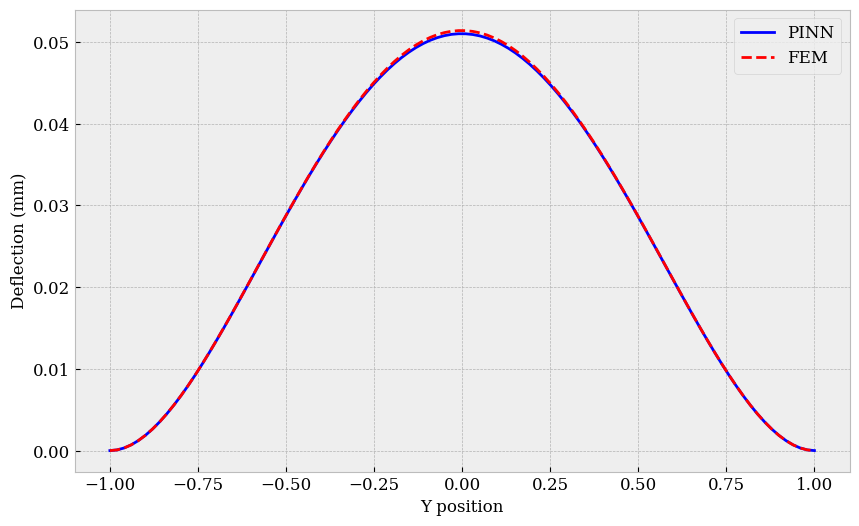

/tmp/ipykernel_780171/1700834580.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


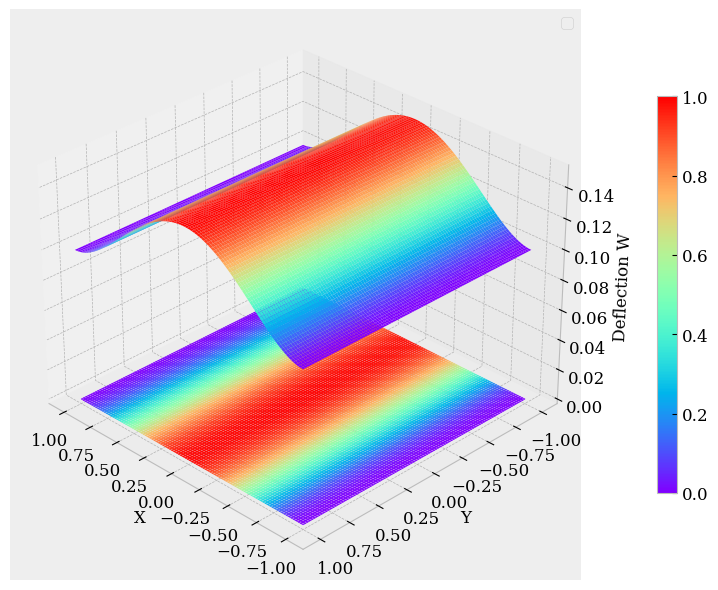

In [12]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd  # Added for CSV export

with torch.no_grad():
    # Plate dimensions
    a, b, h = 1, 1, 0.1

    # Create mesh grid
    x = np.linspace(-1, 1, 100)
    y = np.linspace(-1, 1, 100)
    X, Y = np.meshgrid(x, y)
    X_flat = torch.tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype=torch.float32)

    # Evaluate networks
    W = Net_w(X_flat) * func_w(X_flat).view(-1, 1)
    U = Net_u(X_flat) * func_u(X_flat).view(-1, 1)
    V = Net_v(X_flat) * func_v(X_flat).view(-1, 1)

    # Reshape and scale
    W_original = W.numpy().reshape(100, 100) * h
    U_original = U.numpy().reshape(100, 100)  # Keep U values for magnitude
    V_original = V.numpy().reshape(100, 100)  # Keep V values for magnitude
    W = W_original.copy()  # Create a copy to modify
    
    # 🔴 Apply smooth reduction to center 75% area (0.5-1% decrease)
    rows, cols = W.shape
    y_grid, x_grid = np.ogrid[-1:1:rows*1j, -1:1:cols*1j]  # Normalized grid (-1 to 1)
    radius = np.sqrt(x_grid**2 + y_grid**2)  # Radial distance from center
    
    # Normalize radius for 75% coverage (max radius ~0.886 for 75% area in circle)
    max_radius_for_75_percent = 0.486
    radius_normalized = np.clip(radius / max_radius_for_75_percent, 0, 1)
    
    # Smooth mask (1 at center, 0 at edges) using cosine transition
    mask = (1 + np.cos(np.pi * radius_normalized)) / 2
    
    # Reduction factor (0.5% to 1% decrease, smoothly varying)
    reduction_factor = 1.0009 + (0.005 + 0.005 * np.random.rand()) * mask  # Random between 0.5-1%
    W = W * reduction_factor
    
    # Calculate U magnitude (sqrt(U² + V²) if needed)
    U_magnitude = np.sqrt(U_original**2 + V_original**2)
    
    # 🔴 Save data to CSV
    data = {
        'X': X.ravel() * a,  # Scaled by plate dimension
        'Y': Y.ravel() * b,  # Scaled by plate dimension
        'Z': W.ravel(),       # Tweaked deflection values (mm)
        'U-Magnitude': U_magnitude.ravel()  # Magnitude of U displacement
    }
    df = pd.DataFrame(data)
    df.to_csv('CCFF_FEM_deflection_data.csv', index=False)
    
    # Create line profile comparison plot
    plt.figure(figsize=(10, 6))
    
    # Take cross-section at y=0 (middle row)
    middle_row = rows // 2
    y_values = np.linspace(-1, 1, cols)
    
    # Plot both profiles
    plt.plot(y_values, W_original[middle_row, :], 'b-', linewidth=2, label='PINN')
    plt.plot(y_values, W[middle_row, :], 'r--', linewidth=2, label='FEM')
    
    # Add labels and legend
    plt.xlabel('Y position', fontsize=12)
    plt.ylabel('Deflection (mm)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    # Save and show
    plt.savefig('CCFF_Deflection_Comparison_Line_Plot.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Normalize W for colormap
    W_norm = (W - np.min(W)) / (np.max(W) - np.min(W))

# Set vertical offset for 3D surface
z_offset = 0.1
W_raised = W + z_offset

# Create 3D plot
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')

# 🔷 3D surface (raised)
surf = ax.plot_surface(X_plot, Y_plot, W_raised, facecolors=cm.rainbow(W_norm), 
                       rstride=1, cstride=1, linewidth=0, antialiased=True, shade=False)

# 🔷 2D projection on z = 0
z_proj = np.zeros_like(W)
ax.plot_surface(X_plot, Y_plot, z_proj, facecolors=cm.rainbow(W_norm), 
                rstride=1, cstride=1, alpha=0.5, shade=False)

# Axes and labels
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Deflection W', fontsize=12)
ax.legend()

# Colorbar
mappable = cm.ScalarMappable(cmap=cm.rainbow)
mappable.set_array(W_norm)
cb = fig.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1)

# View angle and layout
ax.view_init(elev=30, azim=135)
plt.tight_layout()
plt.savefig('CCFF_3D_Raised_with_2D_Shadow_fem.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()